## Dependencies

In [1]:
import pandas as pd
import os
import shutil
from DicomRTTool.ReaderWriter import DicomReaderWriter # pip install DicomRTTool
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_style("whitegrid", {'axes.grid' : False})

## Helper functions

In [2]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [3]:
def z_norm(image):
    """
    Standardizes voxel intensities with respect to voxel intensities all voxels in image. 
        Parameters:
            image (np array): nxnxn array corresponding to image. 
        Returns:
            new_image (np array): nxnxn array corresponding to image after intensity standardization. 
    """
    mean = np.mean(image)
    std = np.std(image)
    new_image = np.divide((image - mean), std)
    return new_image

In [4]:
def display_slices_ss(image1, image2, skip=1):
    """
    Displays a series of slices in z-direction that contains the segmented regions of interest.
    Ensures all contours are displayed in consistent and different colors.
        Parameters:
            image (array-like): Numpy array of image.
            mask (array-like): Numpy array of mask.
            skip (int): Only print every nth slice, i.e. if 3 only print every 3rd slice, default 1.
        Returns:
            None (series of in-line plots).
    """

    slice_locations = np.unique(np.where(image1 != 0)[0]) # get indexes for where there is a contour present 
    slice_start = slice_locations[0] # first slice of contour 
    slice_end = slice_locations[len(slice_locations)-1] # last slice of contour
    
    counter = 1
    
    for img_arr1, img_arr2 in zip(image1[slice_start:slice_end+1], image2[slice_start:slice_end+1]): # plot the slices with contours overlayed ontop
        if counter % skip == 0: # if current slice is divisible by desired skip amount 
            fig, (ax1, ax2) = plt.subplots(1,2, gridspec_kw = {'wspace':0, 'hspace':0})
            
            img_arr1 = z_norm(img_arr1)
            img_arr2 = z_norm(img_arr2)
            
            img_arr1 = crop_center(img_arr1, 350, 350)
            img_arr2 = crop_center(img_arr2, 350, 350)
            
            
            ax1.imshow(img_arr1, cmap='gray', interpolation='none', vmin = np.min(img_arr1), vmax = np.percentile(img_arr1, 99))
            ax1.set_xticks([])
            ax1.set_yticks([])
            ax2.imshow(img_arr2, cmap='gray', interpolation='none', vmin = np.min(img_arr1), vmax = np.percentile(img_arr1, 99))
            ax2.set_xticks([])
            ax2.set_yticks([])
            plt.show()
        counter += 1

In [5]:
# modified for file output WITH RANDOMIZATINON, ASSUMES GT IS FIRST ELEMENT, SYN IS SECOND ELEMENT
def display_slices_ss_key(gt_image, syn_image, df_key, output_dir, MRN, skip=1):
    """
    Displays a series of slices in z-direction that contains the segmented regions of interest.
    Ensures all contours are displayed in consistent and different colors.
        Parameters:
            image (array-like): Numpy array of image.
            mask (array-like): Numpy array of mask.
            skip (int): Only print every nth slice, i.e. if 3 only print every 3rd slice, default 1.
        Returns:
            None (series of in-line plots).
    """

    slice_locations = np.unique(np.where(gt_image != 0)[0]) # get indexes for where there is a contour present 
    slice_start = slice_locations[0] # first slice of contour 
    slice_end = slice_locations[len(slice_locations)-1] # last slice of contour
    
    counter = 1
    
    for gt_img_arr, syn_img_arr in zip(gt_image[slice_start:slice_end+1], syn_image[slice_start:slice_end+1]): # plot the slices with contours overlayed ontop
        if counter % skip == 0: # if current slice is divisible by desired skip amount 
            
            #print(counter)
            
            gt_img_arr_location = df_key[(df_key["MRN"] == int(MRN)) & (df_key["Slice"] == counter)]["Ground-Truth Image Position"].values[0]
            
            fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,8), gridspec_kw = {'wspace':0, 'hspace':0}) # remove whitespace
            
            gt_img_arr = z_norm(gt_img_arr)
            syn_img_arr = z_norm(syn_img_arr)
            
            gt_img_arr = crop_center(gt_img_arr, 350, 350)
            syn_img_arr = crop_center(syn_img_arr, 350, 350)
            
            
            if gt_img_arr_location == "Left":
                ax1.imshow(gt_img_arr, cmap='gray', interpolation='none', vmin = np.min(gt_img_arr), vmax = np.percentile(gt_img_arr, 99))
                ax2.imshow(syn_img_arr, cmap='gray', interpolation='none', vmin = np.min(gt_img_arr), vmax = np.percentile(gt_img_arr, 99))
            else:
                ax1.imshow(syn_img_arr, cmap='gray', interpolation='none', vmin = np.min(gt_img_arr), vmax = np.percentile(gt_img_arr, 99))
                ax2.imshow(gt_img_arr, cmap='gray', interpolation='none', vmin = np.min(gt_img_arr), vmax = np.percentile(gt_img_arr, 99))
            ax1.set_xticks([])
            ax1.set_yticks([])
            ax2.set_xticks([])
            ax2.set_yticks([])
            
            ax1.text(0.1, 0.9, 'Left', size=15, color='white', horizontalalignment='center',verticalalignment='center', transform=ax1.transAxes)
            ax2.text(0.15, 0.9, 'Right', size=15, color='white', horizontalalignment='center',verticalalignment='center', transform=ax2.transAxes)
            
            plt.savefig(os.path.join(output_dir, MRN+'_slice_'+str(counter)+'.png'))
            #plt.show()
            plt.close()
            
        counter += 1

## Turing test analysis

Uses a fully anonymized key with no real patient MRNs.

In [6]:
def convert_preference(row):
    if row['Ground-Truth Image Position'] == row['I prefer']:
        val = "Ground-Truth"
    elif row['Synthetic Image Position'] == row['I prefer']:
        val = "Synthetic"
    return val

In [7]:
def convert_impression_gt(row):
    if row['Ground-Truth Image Position'] == "Left" and row["Left image impression"] == "Real":
        val = "Correct"
    elif row['Ground-Truth Image Position'] == "Right" and row["Right image impression"] == "Real":
        val = "Correct"
    else:
        val = "Incorrect"
    return val

In [8]:
def convert_impression_syn(row):
    if row['Synthetic Image Position'] == "Left" and row["Left image impression"] == "AI":
        val = "Correct"
    elif row['Synthetic Image Position'] == "Right" and row["Right image impression"] == "AI":
        val = "Correct"
    else:
        val = "Incorrect"
    return val

In [9]:
# loop version here 

df_key = pd.read_csv('Turing_test_slice_key_v2_FULLYANONYMIZED_FINAL.csv')
subset_df = pd.read_csv('Turing_test_subset_information_withanonkey_v2_FULLYANONYMIZED_FINAL.csv')
observer_files = ["Turing_test_v2_obs1.xlsx", "Turing_test_v2_obs2.xlsx", "Turing_test_v2_obs3.xlsx"]


for n, observer_file in enumerate(observer_files):
    observer_df = pd.read_excel(observer_file)
    
    anon_to_real = {row['anon_ID']: row['File_name'] for index, row in subset_df.iterrows()}
    anon_to_ROI = {row['anon_ID']: row['ROI'] for index, row in subset_df.iterrows()}
    
    observer_df['File_name'] = observer_df['Anonymized_ID'].map(anon_to_real)
    observer_df['ROI'] = observer_df['Anonymized_ID'].map(anon_to_ROI)
    
    real_to_gt = {str(row['MRN'])+ '_slice_'+ str(row['Slice']): row['Ground-Truth Image Position'] for index, row in df_key.iterrows()}
    real_to_synthetic = {str(row['MRN'])+ '_slice_'+ str(row['Slice']): row['Synthetic Image Position'] for index, row in df_key.iterrows()}
    
    observer_df['Ground-Truth Image Position'] = observer_df['File_name'].map(real_to_gt)
    observer_df['Synthetic Image Position'] = observer_df['File_name'].map(real_to_synthetic)
    
    observer_df['Preference'] = observer_df.apply(convert_preference, axis=1)
    observer_df['Ground-Truth Impression'] = observer_df.apply(convert_impression_gt, axis=1)
    observer_df['Synthetic Impression'] = observer_df.apply(convert_impression_syn, axis=1)
    if n == 0:
        main_df = observer_df.copy()
    else:
        main_df = pd.concat([main_df, observer_df], ignore_index = True)
    

In [10]:
main_df

,Annotator_name,Anonymized_ID,Left image impression,Right image impression,I prefer,Comments,File_name,ROI,Ground-Truth Image Position,Synthetic Image Position,Preference,Ground-Truth Impression,Synthetic Impression
0,Observer 1,1,AI,Real,Left,Left has better margins between structures,3641355426_slice_163,Submandibular,Left,Right,Ground-Truth,Incorrect,Incorrect
1,Observer 1,2,AI,Real,Left,Better visualization of Rt level 2 cervical LN,3376859407_slice_120,Mandible,Left,Right,Ground-Truth,Incorrect,Incorrect
2,Observer 1,3,Real,AI,Right,Better visualization of tumor at BOT,3376859407_slice_122,Mandible,Left,Right,Synthetic,Correct,Correct
3,Observer 1,4,AI,Real,Left,NaN,2589026023_slice_133,Node,Right,Left,Synthetic,Correct,Correct
4,Observer 1,5,Real,AI,Left,NaN,2589026023_slice_154,Mandible,Left,Right,Ground-Truth,Correct,Correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Observer 3,96,AI,Real,Right,NaN,3244262639_slice_127,Tumor,Right,Left,Ground-Truth,Correct,Correct
296,Observer 3,97,Real,AI,Left,NaN,3641355426_slice_154,Node,Left,Right,Ground-Truth,Correct,Correct
297,Observer 3,98,AI,Real,Right,pharnex not clear,2589026023_slice_134,Node,Left,Right,Synthetic,Incorrect,Incorrect
298,Observer 3,99,Real,AI,Left,muscles spaces and glands are not clearly lined,1389864037_slice_120,Mandible,Right,Left,Synthetic,Incorrect,Incorrect


In [13]:
%config InlineBackend.figure_format='retina' # for high quality plot

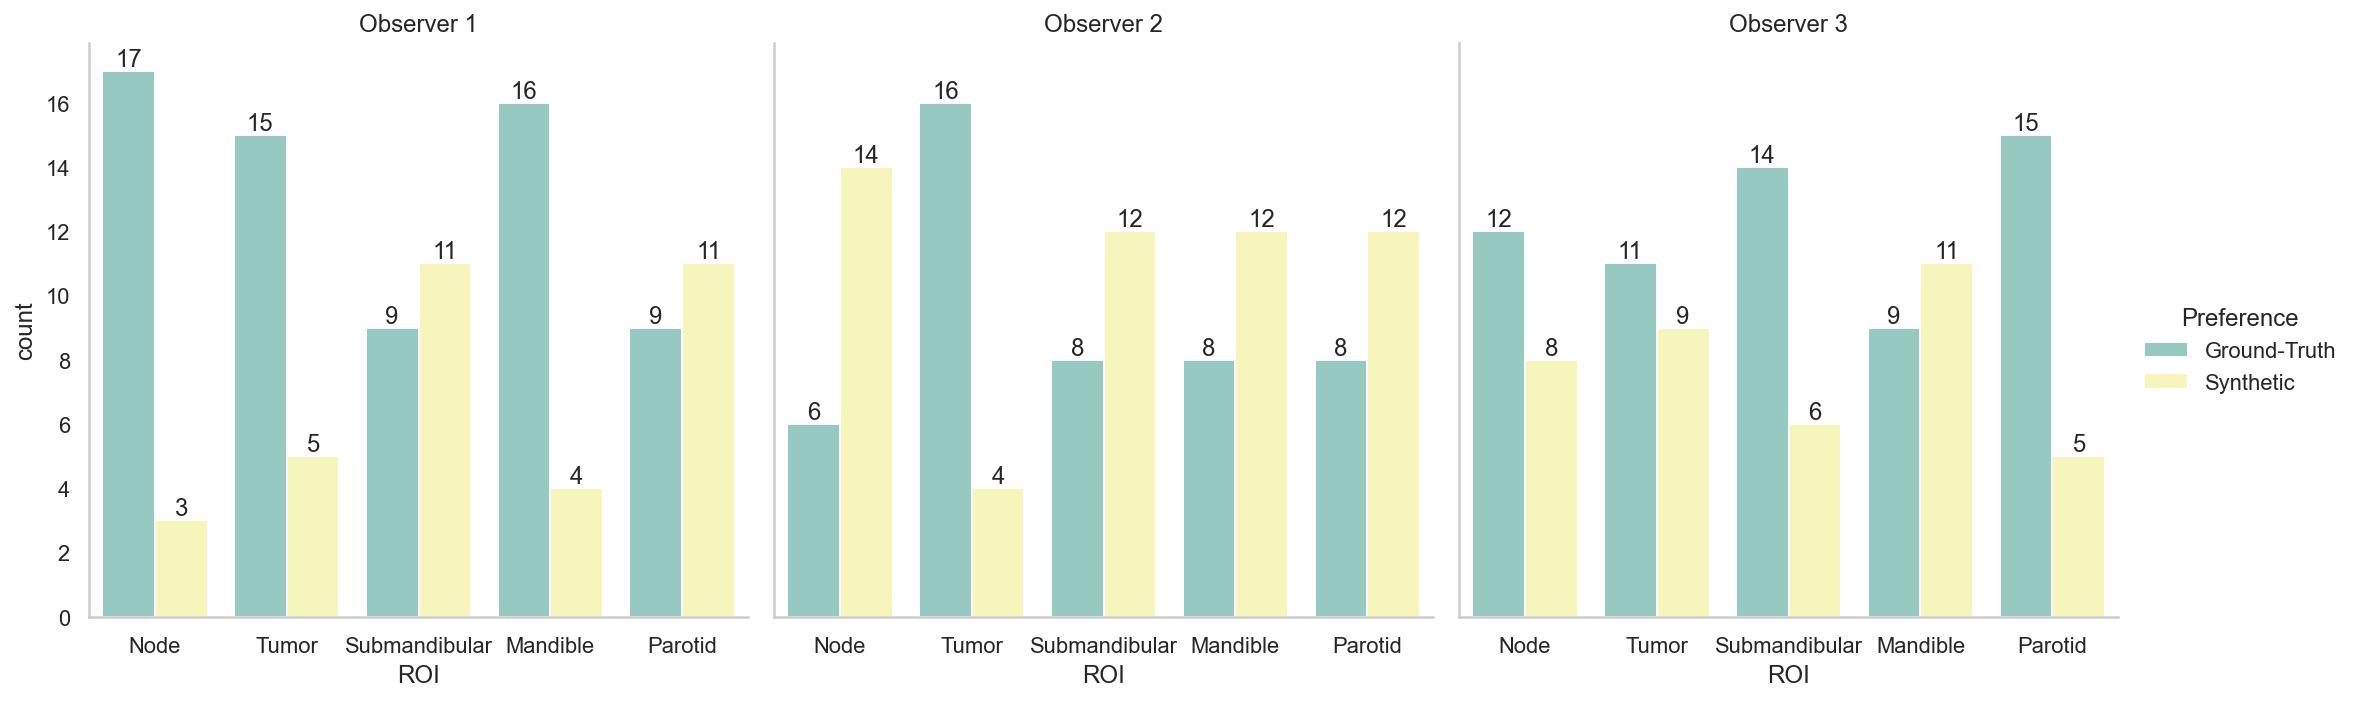

In [14]:
g = sns.catplot(x = "ROI", hue="Preference", col="Annotator_name", data=main_df, kind="count", palette="Set3", 
                hue_order = ["Ground-Truth", "Synthetic"],
               order = ["Node", "Tumor", "Submandibular", "Mandible", "Parotid"]
               )

axes = g.axes.flatten()

axes[0].set_title("Observer 1")
axes[1].set_title("Observer 2")
axes[2].set_title("Observer 3")

for ax in axes:
    for container in ax.containers:
        ax.bar_label(container) # https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values

## Stats

In [15]:
import rpy2.robjects as robjects # conda install to access R 
from rpy2.robjects.packages import importr

Unable to determine R home: [WinError 2] The system cannot find the file specified
Unable to determine R library path: Command '('C:\\Program Files\\R\\R-4.1.3\\bin\\Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.


In [16]:
importr('TOSTER') # import the R package we need

rpy2.robjects.packages.Package as a <module 'TOSTER'>

In [17]:
TOSTtwoprop = robjects.r["TOSTtwo.prop"]

In [18]:
observer_list = ["Observer 1", "Observer 2", "Observer 3"]

for observer in observer_list:
    print(observer)
    sub_df = main_df[main_df["Annotator_name"] == observer]
    
    prop_correct = sub_df["Ground-Truth Impression"].value_counts().max()/100
    output_correct = TOSTtwoprop(prop1 = prop_correct, prop2 = 0.50, n1 = 100, n2 = 100, low_eqbound = -0.3, high_eqbound = 0.3, plot=False)
    p_val_correct = max(output_correct[2][0], output_correct[4][0])

    gt_pref = sub_df["Preference"].value_counts()["Ground-Truth"]/100
    prop_pref = sub_df["Preference"].value_counts().max()/100
    output_pref = TOSTtwoprop(prop1 = prop_pref, prop2 = 0.50, n1 = 100, n2 = 100, low_eqbound = -0.3, high_eqbound = 0.3, plot=False)
    p_val_pref = max(output_pref[2][0], output_pref[4][0])
    
    print(observer, "% correct = ", prop_correct ,", correct p-val = ", p_val_correct, ", % gt preference = ", gt_pref, ", preference p-val", p_val_pref)

Observer 1
TOST results:
Z-value lower bound: 4.38 	p-value lower bound: 0.000006
Z-value upper bound: -4.10 	p-value upper bound: 0.00002

Equivalence bounds:
low eqbound: -0.3 
high eqbound: 0.3

TOST confidence interval:
lower bound 90% CI: -0.106
upper bound 90% CI:  0.126

NHST confidence interval:
lower bound 95% CI: -0.129
upper bound 95% CI:  0.149

Equivalence Test based on Fisher's exact z-test Result:
The equivalence test was significant, Z = -4.102, p = 0.0000205, given equivalence bounds of -0.300 and 0.300 and an alpha of 0.05.

R[write to console]: 




Null-Hypothesis Fisher's exact z-test Result:
The null hypothesis test was non-significant, Z = 0.141, p = 0.888, given an alpha of 0.05.

R[write to console]: 



R[write to console]: NHST: don't reject null significance hypothesis that the effect is equal to 0 
TOST: reject null equivalence hypothesis



TOST results:
Z-value lower bound: 6.68 	p-value lower bound: 0.00000000001
Z-value upper bound: -2.03 	p-value upper bound: 0.021

Equivalence bounds:
low eqbound: -0.3 
high eqbound: 0.3

TOST confidence interval:
lower bound 90% CI: 0.047
upper bound 90% CI:  0.273

NHST confidence interval:
lower bound 95% CI: 0.025
upper bound 95% CI:  0.295

Equivalence Test based on Fisher's exact z-test Result:
The equivalence test was significant, Z = -2.033, p = 0.021, given equivalence bounds of -0.300 and 0.300 and an alpha of 0.05.

R[write to console]: 




Null-Hypothesis Fisher's exact z-test Result:
The null hypothesis test was significant, Z = 2.323, p = 0.0202, given an alpha of 0.05.

R[write to console]: 



R[write to console]: NHST: reject null significance hypothesis
TOST: reject null equivalence hypothesis



Observer 1 % correct =  0.51 , correct p-val =  2.051253863251527e-05 , % gt preference =  0.66 , preference p-val 0.021045582724398562
Observer 2
TOST results:
Z-value lower bound: 5.11 	p-value lower bound: 0.0000002
Z-value upper bound: -3.41 	p-value upper bound: 0.0003

Equivalence bounds:
low eqbound: -0.3 
high eqbound: 0.3

TOST confidence interval:
lower bound 90% CI: -0.056
upper bound 90% CI:  0.176

NHST confidence interval:
lower bound 95% CI: -0.078
upper bound 95% CI:  0.198

Equivalence Test based on Fisher's exact z-test Result:
The equivalence test was significant, Z = -3.406, p = 0.000329, given equivalence bounds of -0.300 and 0.300 and an alpha of 0.05.

R[write to console]: 




Null-Hypothesis Fisher's exact z-test Result:
The null hypothesis test was non-significant, Z = 0.852, p = 0.394, given an alpha of 0.05.

R[write to console]: 



R[write to console]: NHST: don't reject null significance hypothesis that the effect is equal to 0 
TOST: reject null equivalence hypothesis



TOST results:
Z-value lower bound: 4.82 	p-value lower bound: 0.0000007
Z-value upper bound: -3.68 	p-value upper bound: 0.0001

Equivalence bounds:
low eqbound: -0.3 
high eqbound: 0.3

TOST confidence interval:
lower bound 90% CI: -0.076
upper bound 90% CI:  0.156

NHST confidence interval:
lower bound 95% CI: -0.098
upper bound 95% CI:  0.178

Equivalence Test based on Fisher's exact z-test Result:
The equivalence test was significant, Z = -3.683, p = 0.000115, given equivalence bounds of -0.300 and 0.300 and an alpha of 0.05.

R[write to console]: 




Null-Hypothesis Fisher's exact z-test Result:
The null hypothesis test was non-significant, Z = 0.567, p = 0.571, given an alpha of 0.05.

R[write to console]: 



R[write to console]: NHST: don't reject null significance hypothesis that the effect is equal to 0 
TOST: reject null equivalence hypothesis



Observer 2 % correct =  0.56 , correct p-val =  0.0003291310299401967 , % gt preference =  0.46 , preference p-val 0.00011531928926142975
Observer 3
TOST results:
Z-value lower bound: 5.56 	p-value lower bound: 0.00000001
Z-value upper bound: -2.99 	p-value upper bound: 0.001

Equivalence bounds:
low eqbound: -0.3 
high eqbound: 0.3

TOST confidence interval:
lower bound 90% CI: -0.025
upper bound 90% CI:  0.205

NHST confidence interval:
lower bound 95% CI: -0.047
upper bound 95% CI:  0.227

Equivalence Test based on Fisher's exact z-test Result:
The equivalence test was significant, Z = -2.994, p = 0.00138, given equivalence bounds of -0.300 and 0.300 and an alpha of 0.05.

R[write to console]: 




Null-Hypothesis Fisher's exact z-test Result:
The null hypothesis test was non-significant, Z = 1.283, p = 0.199, given an alpha of 0.05.

R[write to console]: 



R[write to console]: NHST: don't reject null significance hypothesis that the effect is equal to 0 
TOST: reject null equivalence hypothesis



TOST results:
Z-value lower bound: 5.87 	p-value lower bound: 0.000000002
Z-value upper bound: -2.72 	p-value upper bound: 0.003

Equivalence bounds:
low eqbound: -0.3 
high eqbound: 0.3

TOST confidence interval:
lower bound 90% CI: -0.005
upper bound 90% CI:  0.225

NHST confidence interval:
lower bound 95% CI: -0.027
upper bound 95% CI:  0.247

Equivalence Test based on Fisher's exact z-test Result:
The equivalence test was significant, Z = -2.720, p = 0.00326, given equivalence bounds of -0.300 and 0.300 and an alpha of 0.05.

R[write to console]: 




Null-Hypothesis Fisher's exact z-test Result:
The null hypothesis test was non-significant, Z = 1.575, p = 0.115, given an alpha of 0.05.

R[write to console]: 



R[write to console]: NHST: don't reject null significance hypothesis that the effect is equal to 0 
TOST: reject null equivalence hypothesis



Observer 3 % correct =  0.59 , correct p-val =  0.0013758251328884678 , % gt preference =  0.61 , preference p-val 0.003262903545096047


## Turing test file generation 

Code to generate files for Turing test will not be exactly the same since we used the actual MRNs in the original generation and they have been anonymized. The code below is only for documenting the process, to get the exact same output require using real MRNs which are located in Fuller shared drives. Code below is just for public distribution of code to replicate our study generally. Again, code below will not run properly without reference to the real MRNs.. 

In [ ]:
MRN_list = [INSERT, INSERT, INSERT, INSERT, INSERT] # these are MRNs we will focus on 

Populate dataframe with random left/right image mapping for each slice for each patient.

In [ ]:
%%time

## NEED TO EDIT THIS TO ACTUALLY ACCOUNT FOR NUMBER OF SLICES IN IMAGES, there are some that arent 227 or whatver 

import random
np.random.seed(0) # set this just in case 

df = pd.DataFrame(columns=['MRN', 'Slice', 'Ground-Truth Image Position', 'Synthetic Image Position']) # make dataframe
counter = -1  

rand_counter = -1

path = "Final"
MRN_folders = os.listdir(path)

for MRN_folder in MRN_folders:
    MRN = int(MRN_folder)
    if MRN in MRN_list:
        print(MRN_folder)
        MRN_folder_path = os.path.join(path, MRN_folder)

        N4_path = os.path.join(MRN_folder_path, "6min_real_N4")

        files_length = len(os.listdir(N4_path))
        print(files_length)

        for x in range(1, files_length+1):

            lst = ["Left", "Right"]

            rand_counter +=1 
            random.seed(rand_counter)

            gt_label = random.sample(lst,1)[0]
            #print(gt_label)
            lst.remove(gt_label) # remove from lsit 
            syn_label = lst[0] # gives the remainder, i.e. if label 1 is A label 2 is B
            #print(syn_label)

            counter +=1
            df.loc[counter] = [MRN, x, gt_label, syn_label] # add to dataframe here

In [ ]:
#df.to_csv('Turing_test_slice_key.csv', index=False) # save

In [ ]:
#df_key = pd.read_csv('Turing_test_slice_key_v2.csv')

Create paired images with labels generated above.

In [ ]:
%%time

# loop to see all the cases NEW WITH DATAFRAME KEY VERSION

path = "nifti_output"

output_path = "Turing_test_paired_images"
if not os.path.exists(output_path):
    os.makedirs(output_path)

MRN_folders = os.listdir(path)

for MRN_folder in MRN_folders:
    if int(MRN_folder) in MRN_list:
        print(MRN_folder)        
        
        MRN_folder_path = os.path.join(path, MRN_folder)
        
        gt_image_file = os.path.join(MRN_folder_path, "6min_real_N4_image.nii.gz")
        syn_image_file = os.path.join(MRN_folder_path, "6min_synthetic_N4_image.nii.gz")
        
        gt_image_sitk = sitk.ReadImage(gt_image_file)
        syn_image_sitk = sitk.ReadImage(syn_image_file)

        gt_image = sitk.GetArrayFromImage(gt_image_sitk)
        
        syn_image = sitk.GetArrayFromImage(syn_image_sitk)
        
        syn_image_norm = z_norm(syn_image)
        gt_image_norm = z_norm(gt_image)
        
        #display_slices_ss_key(gt_image_norm, syn_image_norm, df_key, output_path, MRN_folder) 

        

In [ ]:
excel_sheet_before = "Turing_test_subset_information.xlsx"

In [ ]:
subset_df = pd.read_excel(excel_sheet_before)

Now can generate "blinded" ID mapping so physicians don't know which slices correspond to specific patients.

In [ ]:
np.random.seed(0) # set this just in case 
random.seed(0)

anonymization_column_list = []

number_list = list(range(1,101))

for x in range(1,101):
    anonymization_ID = random.sample(number_list,1)[0] # randomly grab one element from number list 
    anonymization_column_list.append(anonymization_ID) # add to column data
    number_list.remove(anonymization_ID) # remove from pool of numbers to assign

In [ ]:
subset_df['anon_ID'] = anonymization_column_list

In [ ]:
#subset_df.to_csv('Turing_test_subset_information_withanonkey.csv', index=False) # save

Now copy subset to new folder based on if its in the dataframe and rename.

In [ ]:
output_folder = "Turing_test_paired_images_subset"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

image_folder = "Turing_test_paired_images"
images = os.listdir(image_folder)

for file in images:
    file_path = os.path.join(image_folder, file)
    
    file_name = file.split('.')[0]
    
    if file_name in subset_df['File_name'].tolist():
        anonymized_id = str(subset_df[subset_df['File_name'] == file_name]['anon_ID'].values[0])
        new_file_path = os.path.join(output_folder, anonymized_id+'.png')
        #shutil.copyfile(file_path, new_file_path)
        